In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

raw_df = pd.read_csv("anes_timeseries_cdf_csv_20211118/anes_timeseries_cdf_csv_20211118.csv", low_memory=False)

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Subset

vars = {
    "VCF0004": "year",
    "VCF0301": "party",
    "VCF0803": "ideo",
    "VCF0009z": "weightz",
    "VCF0211": "thermo_liberals",
    "VCF0212": "thermo_conservatives",
    "VCF0218": "thermo_democratparty",
    "VCF0224": "thermo_republicanparty",
    "VCF0830": "abram_civil_aid_to_blacks",
    # "VCF0803": "abram_ideo", # Note: cannot use VCF0803 twice (for ideo and abram_ideo) here, so added in pre-processing block
    "VCF0843": "abram_foreign_defense_spending",
    "VCF0809": "abram_econ_guarantee_jobs",
    "VCF0806": "abram_econ_health_insurance",
    "VCF0839": "abram_econ_gov_services",
    "VCF0838": "abram_moral_abortion_allowed_law",
}
df = raw_df.loc[:, vars.keys()]
df.rename(columns=vars, inplace=True)

In [ ]:
# Preprocessing

orig_ideo = df["ideo"]

df["party"] = df["party"].replace([" ", "0"], np.nan).transform(lambda x: int(x) - 4 if not pd.isnull(x) else np.nan)
df["ideo"] = df["ideo"].replace([" ", "0", "9"], np.nan).transform(lambda x: int(x) - 4 if not pd.isnull(x) else np.nan)
df["weightz"] = pd.to_numeric(df["weightz"].replace([" "], np.nan))
df["thermo_liberals"] = pd.to_numeric(df["thermo_liberals"].replace([" ", "98", "99"], np.nan))
df["thermo_conservatives"] = pd.to_numeric(df["thermo_conservatives"].replace([" ", "98", "99"], np.nan))
df["thermo_democratparty"] = pd.to_numeric(df["thermo_democratparty"].replace([" ", "98", "99"], np.nan))
df["thermo_republicanparty"] = pd.to_numeric(df["thermo_republicanparty"].replace([" ", "98", "99"], np.nan))

df["abram_civil_aid_to_blacks"] = pd.to_numeric(df["abram_civil_aid_to_blacks"].replace([" ", "0", "9", "1", "2", "3", "4", "5", "6", "7"], [np.nan, np.nan, 0, -1, -1, -1, 0, 1, 1, 1]))
# Adding in copy of VCF0803 here
df["abram_ideo"] = pd.to_numeric(orig_ideo.replace([" ", "0", "9", "1", "2", "3", "4", "5", "6", "7"], [np.nan, np.nan, 0, -1, -1, -1, 0, 1, 1, 1]))
df["abram_foreign_defense_spending"] = pd.to_numeric(df["abram_foreign_defense_spending"].replace([" ", "0", "9", "1", "2", "3", "4", "5", "6", "7"], [np.nan, np.nan, 0, -1, -1, -1, 0, 1, 1, 1]))
df["abram_econ_guarantee_jobs"] = pd.to_numeric(df["abram_econ_guarantee_jobs"].replace([" ", "0", "9", "1", "2", "3", "4", "5", "6", "7"], [np.nan, np.nan, 0, -1, -1, -1, 0, 1, 1, 1]))
df["abram_econ_health_insurance"] = pd.to_numeric(df["abram_econ_health_insurance"].replace([" ", "0", "9", "1", "2", "3", "4", "5", "6", "7"], [np.nan, np.nan, 0, -1, -1, -1, 0, 1, 1, 1]))
df["abram_econ_gov_services"] = pd.to_numeric(df["abram_econ_gov_services"].replace([" ", "0", "9", "1", "2", "3", "4", "5", "6", "7"], [np.nan, np.nan, 0, 1, 1, 1, 0, -1, -1, -1]))
df["abram_moral_abortion_allowed_law"] = pd.to_numeric(df["abram_moral_abortion_allowed_law"].replace([" ", "0", "9", "1", "2", "3", "4"], [np.nan, np.nan, 0, 1, 1, 0, -1]))

In [ ]:
# Affect - Ideological

data = df.dropna(subset=["party", "ideo", "thermo_liberals", "thermo_conservatives", "weightz"])
data = data[(data["ideo"] >= -3) & (data["ideo"] <= 3) & (data["ideo"] != 0)]
dem = (data["ideo"] < 0)
rep = (data["ideo"] > 0)

data.insert(0, "polar", None)
data.loc[dem, "polar"] = data.loc[dem, "thermo_liberals"] - data.loc[dem, "thermo_conservatives"]
data.loc[rep, "polar"] = data.loc[rep, "thermo_conservatives"] - data.loc[rep, "thermo_liberals"]

data_r = data[rep]
data_d = data[dem]

wm = lambda x: np.average(x["polar"], weights=data.loc[x["polar"].index, "weightz"])
avg_data_r = data_r.groupby("year").apply(wm)
avg_data_d = data_d.groupby("year").apply(wm)
avg_data = pd.concat([avg_data_r, avg_data_d]).groupby("year").apply(sum)

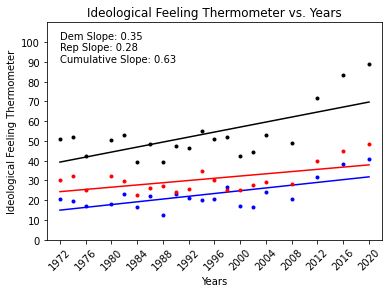

In [ ]:
data = pd.concat([data_r, data_d])
number_of_responses_by_year = data.groupby("year").size()
errorbar = {}
for d in data.values:
    polar = d[0]
    year = int(d[1])
    weight = d[4]
    if year not in errorbar:
        errorbar[year] = 0
    errorbar[year] += np.square(weight / number_of_responses_by_year[year]) * avg_data[year]

for year in errorbar:
    errorbar[year] = np.sqrt(errorbar[year])

x = np.array([int(a) for a in dict(avg_data).keys()])
y = list(dict(avg_data).values())
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="black")
plt.errorbar(x, y, yerr=list(errorbar.values()), fmt=".", color="black")

#####

data = pd.concat([data_r, data_d])
number_of_responses_by_year_d = data_d.groupby("year").size()
number_of_responses_by_year_r = data_r.groupby("year").size()
errorbar_d = {}
errorbar_r = {}
for d in data_d.values:
    year = int(d[1])
    weight = d[4]
    if year not in errorbar_d:
        errorbar_d[year] = 0
    errorbar_d[year] += np.square(weight / number_of_responses_by_year_d[year]) * avg_data_d[year]

for d in data_r.values:
    year = int(d[1])
    weight = d[4]
    if year not in errorbar_r:
        errorbar_r[year] = 0
    errorbar_r[year] += np.square(weight / number_of_responses_by_year_r[year]) * avg_data_r[year]

for year in errorbar_d:
    errorbar_d[year] = np.sqrt(errorbar_d[year])
for year in errorbar_r:
    errorbar_r[year] = np.sqrt(errorbar_r[year])

x_d = np.array([int(a) for a in dict(avg_data_d).keys()])
x_r = np.array([int(a) for a in dict(avg_data_r).keys()])
y_d = list(dict(avg_data_d).values())
y_r = list(dict(avg_data_r).values())
m_d, b_d = np.polyfit(x_d, y_d, 1)
m_r, b_r = np.polyfit(x_r, y_r, 1)
plt.plot(x_d, m_d*x_d + b_d, color="blue")
plt.plot(x_r, m_r*x_r + b_r, color="red")
plt.errorbar(x_d, y_d, yerr=list(errorbar_d.values()), fmt=".", color="blue")
plt.errorbar(x_r, y_r, yerr=list(errorbar_r.values()), fmt=".", color="red")
plt.title("Ideological Feeling Thermometer vs. Years")
plt.xlabel("Years")
plt.ylabel("Ideological Feeling Thermometer")
plt.text(1972, 90, f"Dem Slope: {np.round(m_d, 2)}\nRep Slope: {np.round(m_r, 2)}\nCumulative Slope: {np.round(m, 2)}")
plt.ylim(0, 110)
plt.yticks(np.arange(0, 110, step=10))
plt.xlim(1970, 2022)
plt.xticks(np.arange(1972, 2021, step=4), rotation=45)
plt.show()

In [ ]:
# Affect - Party

datap = df.dropna(subset=["party", "ideo", "thermo_democratparty", "thermo_republicanparty", "weightz"])
datap = datap[(datap["party"] >= -3) & (datap["party"] <= 3) & (datap["party"] != 0)]
dem = (datap["party"] < 0)
rep = (datap["party"] > 0)

datap.insert(0, "polar", None)
dem_in_group = datap.loc[dem, "thermo_democratparty"]
dem_out_group = datap.loc[dem, "thermo_republicanparty"]
rep_in_group = datap.loc[rep, "thermo_republicanparty"]
rep_out_group = datap.loc[rep, "thermo_democratparty"]
datap.loc[dem, "polar"] = dem_in_group - dem_out_group
datap.loc[rep, "polar"] = rep_in_group - rep_out_group

datap_r = datap[rep]
datap_d = datap[dem]

wmp = lambda x: np.average(x["polar"], weights=datap.loc[x["polar"].index, "weightz"])
wmp_dem_party = lambda x: np.average(x["thermo_democratparty"], weights=datap.loc[x["thermo_democratparty"].index, "weightz"])
wmp_rep_party = lambda x: np.average(x["thermo_republicanparty"], weights=datap.loc[x["thermo_republicanparty"].index, "weightz"])
avg_datap_r = datap_r.groupby("year").apply(wmp)
avg_datap_d = datap_d.groupby("year").apply(wmp)

avg_datap_dem_in_group = datap_d.groupby("year").apply(wmp_dem_party).groupby("year").apply(sum)
avg_datap_dem_out_group = datap_d.groupby("year").apply(wmp_rep_party).groupby("year").apply(sum)
avg_datap_rep_in_group = datap_r.groupby("year").apply(wmp_rep_party).groupby("year").apply(sum)
avg_datap_rep_out_group = datap_r.groupby("year").apply(wmp_dem_party).groupby("year").apply(sum)

avg_datap = pd.concat([avg_datap_r, avg_datap_d]).groupby("year").apply(sum)

In [ ]:
data = pd.concat([datap_r, datap_d])
number_of_responses_by_year = data.groupby("year").size()
errorbar = {}
for d in data.values:
    polar = d[0]
    year = int(d[1])
    weight = d[4]
    if year not in errorbar:
        errorbar[year] = 0
    errorbar[year] += np.square(weight / number_of_responses_by_year[year]) * avg_datap[year]

for year in errorbar:
    errorbar[year] = np.sqrt(errorbar[year])

x = np.array([int(a) for a in dict(avg_datap).keys()])
y = list(dict(avg_datap).values())
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="black")
plt.errorbar(x, y, yerr=list(errorbar.values()), fmt=".", color="black")

#####

data = pd.concat([datap_r, datap_d])
number_of_responses_by_year_d = datap_d.groupby("year").size()
number_of_responses_by_year_r = datap_r.groupby("year").size()
errorbar_d = {}
errorbar_r = {}
for d in datap_d.values:
    year = int(d[1])
    weight = d[4]
    if year not in errorbar_d:
        errorbar_d[year] = 0
    errorbar_d[year] += np.square(weight / number_of_responses_by_year_d[year]) * avg_datap_d[year]

for d in datap_r.values:
    year = int(d[1])
    weight = d[4]
    if year not in errorbar_r:
        errorbar_r[year] = 0
    errorbar_r[year] += np.square(weight / number_of_responses_by_year_r[year]) * avg_datap_r[year]

for year in errorbar_d:
    errorbar_d[year] = np.sqrt(errorbar_d[year])
for year in errorbar_r:
    errorbar_r[year] = np.sqrt(errorbar_r[year])

x_d = np.array([int(a) for a in dict(avg_datap_d).keys()])
x_r = np.array([int(a) for a in dict(avg_datap_r).keys()])
y_d = list(dict(avg_datap_d).values())
y_r = list(dict(avg_datap_r).values())
m_d, b_d = np.polyfit(x_d, y_d, 1)
m_r, b_r = np.polyfit(x_r, y_r, 1)
plt.plot(x_d, m_d*x_d + b_d, color="blue")
plt.plot(x_r, m_r*x_r + b_r, color="red")
plt.errorbar(x_d, y_d, yerr=list(errorbar_d.values()), fmt=".", color="blue")
plt.errorbar(x_r, y_r, yerr=list(errorbar_r.values()), fmt=".", color="red")
plt.title("Affective Polarization Using ANES Data")
plt.ylabel("Partisan Feeling Thermometer")
plt.text(1972, 90, f"Dem Slope: {np.round(m_d, 2)}\nRep Slope: {np.round(m_r, 2)}\nPolarization Slope: {np.round(m, 2)}")
plt.ylim(0, 110)
plt.yticks(np.arange(0, 110, step=10))
plt.xlim(1970, 2022)
plt.xticks(np.arange(1972, 2021, step=4), rotation=45)
plt.show()

NameError: name 'pd' is not defined

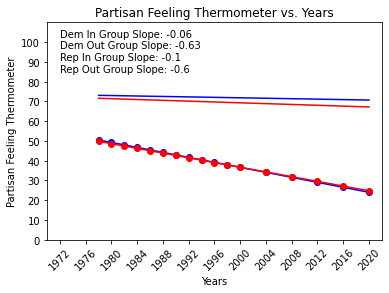

In [ ]:
x_dig = np.array([int(a) for a in dict(avg_datap_dem_in_group).keys()])
x_dog = np.array([int(a) for a in dict(avg_datap_dem_out_group).keys()])
x_rig = np.array([int(a) for a in dict(avg_datap_rep_in_group).keys()])
x_rog = np.array([int(a) for a in dict(avg_datap_rep_out_group).keys()])
y_dig = list(dict(avg_datap_dem_in_group).values())
y_dog = list(dict(avg_datap_dem_out_group).values())
y_rig = list(dict(avg_datap_rep_in_group).values())
y_rog = list(dict(avg_datap_rep_out_group).values())
m_dig, b_dig = np.polyfit(x_dig, y_dig, 1)
m_dog, b_dog = np.polyfit(x_dog, y_dog, 1)
m_rig, b_rig = np.polyfit(x_rig, y_rig, 1)
m_rog, b_rog = np.polyfit(x_rog, y_rog, 1)
plt.plot(x_dig, m_dig*x_dig + b_dig, "b-")
plt.plot(x_dog, m_dog*x_dog + b_dog, "bo-")
plt.plot(x_rig, m_rig*x_rig + b_rig, "r-")
plt.plot(x_rog, m_rog*x_rog + b_rog, "ro-")
plt.title("Partisan Feeling Thermometer vs. Years")
plt.xlabel("Years")
plt.ylabel("Partisan Feeling Thermometer")
plt.text(1972, 85, f"Dem In Group Slope: {np.round(m_dig, 2)}\nDem Out Group Slope: {np.round(m_dog, 2)}\nRep In Group Slope: {np.round(m_rig, 2)}\nRep Out Group Slope: {np.round(m_rog, 2)}")
plt.ylim(0, 110)
plt.yticks(np.arange(0, 110, step=10))
plt.xlim(1970, 2022)
plt.xticks(np.arange(1972, 2021, step=4), rotation=45)
plt.show()

In [ ]:
# Party Sorting

data = df.dropna(subset=["party", "ideo", "weightz"]).loc[:, ["year", "party", "ideo", "weightz"]]
overlap = abs(data["party"] - data["ideo"]) + 1
max_overlap = max(overlap)
min_overlap = min(overlap)
reverse_overlap = (max_overlap + min_overlap) - overlap

party_str = abs(data["party"]) + 1
ideo_str = abs(data["ideo"]) + 1
party_ideo_str = party_str * ideo_str

overlap_str = reverse_overlap * party_ideo_str
data["polar"] = (overlap_str - 7) / 105 # Boxell 2017 Note: Renormalizes between 0 and 1 (same as what Mason (2013) does)

wm = lambda x: np.average(x["polar"], weights=data.loc[x.index, "weightz"])
avg_data = data.groupby("year").apply(wm)

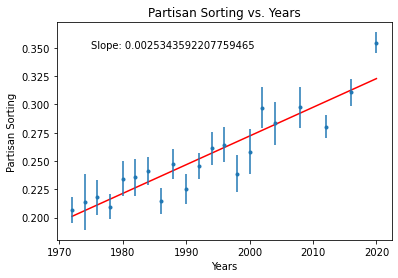

In [ ]:
number_of_responses_by_year = data.groupby("year").size()
errorbar = {}
for d in data.values:
    year = d[0]
    weight = d[3]
    if year not in errorbar:
        errorbar[year] = 0
    errorbar[year] += np.square(weight / number_of_responses_by_year[year]) * avg_data[year]

for year in errorbar:
    errorbar[year] = np.sqrt(errorbar[year])

x = np.array([int(a) for a in dict(avg_data).keys()])
y = list(dict(avg_data).values())
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="red")
plt.errorbar(x, y, yerr=list(errorbar.values()), fmt=".")
plt.title("Partisan Sorting vs. Years")
plt.xlabel("Years")
plt.ylabel("Partisan Sorting")
plt.text(1975, 0.35, f"Slope: {m}")
plt.show()

In [ ]:
# Issue Consistency

data = df.dropna(subset=["abram_ideo", "abram_civil_aid_to_blacks", "abram_foreign_defense_spending", "abram_econ_guarantee_jobs", "abram_econ_health_insurance", "abram_econ_gov_services", "abram_moral_abortion_allowed_law"]).loc[:, ["year", "weightz", "abram_ideo", "abram_civil_aid_to_blacks", "abram_foreign_defense_spending", "abram_econ_guarantee_jobs", "abram_econ_health_insurance", "abram_econ_gov_services", "abram_moral_abortion_allowed_law"]]

data["polar"] = abs(data[["abram_ideo", "abram_civil_aid_to_blacks", "abram_foreign_defense_spending", "abram_econ_guarantee_jobs", "abram_econ_health_insurance", "abram_econ_gov_services", "abram_moral_abortion_allowed_law"]].sum(axis=1))

wm = lambda x: np.average(x["polar"], weights=data.loc[x.index, "weightz"])
avg_data = data.groupby("year").apply(wm)

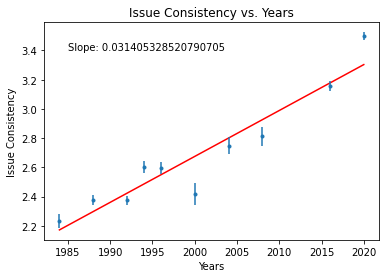

In [ ]:
number_of_responses_by_year = data.groupby("year").size()
errorbar = {}
for d in data.values:
    year = d[0]
    weight = d[1]
    if year not in errorbar:
        errorbar[year] = 0
    errorbar[year] += np.square(weight / number_of_responses_by_year[year]) * avg_data[year]

for year in errorbar:
    errorbar[year] = np.sqrt(errorbar[year])

x = np.array([int(a) for a in dict(avg_data).keys()])
y = list(dict(avg_data).values())
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="red")
plt.errorbar(x, y, yerr=list(errorbar.values()), fmt=".")
plt.title("Issue Consistency vs. Years")
plt.xlabel("Years")
plt.ylabel("Issue Consistency")
plt.text(1985, 3.4, f"Slope: {m}")
plt.show()

In [ ]:
# Issue Divergence

issues = ["abram_ideo", "abram_civil_aid_to_blacks", "abram_foreign_defense_spending", "abram_econ_guarantee_jobs", "abram_econ_health_insurance", "abram_econ_gov_services", "abram_moral_abortion_allowed_law"]
data = df.loc[df["year"] > 1980, ["year", "weightz", "party", *issues]]

data.insert(0, "abram_party", np.nan)
data.loc[(data["party"] > 0), "abram_party"] = 1
data.loc[(data["party"] < 0), "abram_party"] = 0
data = data.dropna()

wm = lambda x: stats.kendalltau(x["abram_party"], x["abram_ideo"]).correlation
avg_data = data.groupby("year").apply(wm)

for issue in issues[1:]:
    wm = lambda x: stats.kendalltau(x["abram_party"], x[issue]).correlation
    avg_data += data.groupby("year").apply(wm)

avg_data = avg_data / len(issues)

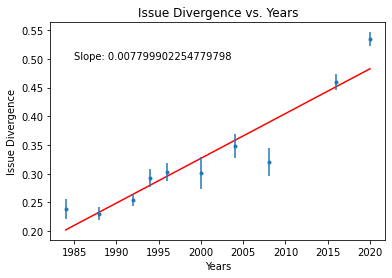

In [ ]:
number_of_responses_by_year = data.groupby("year").size()
errorbar = {}
for d in data.values:
    year = d[1]
    weight = d[2]
    if year not in errorbar:
        errorbar[year] = 0
    errorbar[year] += np.square(weight / number_of_responses_by_year[year]) * avg_data[year]

for year in errorbar:
    errorbar[year] = np.sqrt(errorbar[year])

x = np.array([int(a) for a in dict(avg_data).keys()])
y = list(dict(avg_data).values())
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="red")
plt.errorbar(x, y, yerr=list(errorbar.values()), fmt=".")
plt.title("Issue Divergence vs. Years")
plt.xlabel("Years")
plt.ylabel("Issue Divergence")
plt.text(1985, 0.5, f"Slope: {m}")
plt.show()